In [20]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import stats


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'


import treeswift as ts

In [21]:
tpm_df = pd.read_csv('../data/finz_expression_tpm.txt', sep='\t')
print(tpm_df.loc[tpm_df.finz == True].head())

       gene stageName       tpm  finz  expressed cluster
614250   g1    1-cell  0.003223  True       True    Late
614251   g1    2-cell  0.003063  True       True    Late
614252   g1  128-cell  0.085803  True       True    Late
614253   g1   1k-cell  0.139099  True       True    Late
614254   g1      Dome  4.492337  True       True    Late


In [22]:
def get_midpoints(species, genes=None):
    midpoints = {}
    chroms = {}
    with open(f'../data/gffs/{species}_augustus_finz.gff') as infile:
        infile.readline()
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.split()
            if line[2] != 'gene':
                continue
            gene = line[-1].strip('ID=')
            if genes:
                if gene not in genes:
                    continue
            midpoint = round(min(float(line[3]), float(line[4])) + abs(float(line[4]) - float(line[3]))/2.0)
            midpoints[gene] = midpoint
            chroms[gene] = line[0]
    return midpoints, chroms

def get_chromsizes(species):
    with open(f'../data/beds/{species}.genome') as infile:
        chromsizes = {i.split()[0]: int(i.split()[1]) for i in infile}
    return chromsizes

def get_finz(species):
    finz = []
    with open(f'../data/seqs/{species}_augustus_finz.aa.fa') as infile:
        for line in infile:
            if line.startswith('>'):
                finz.append(line.strip(f'>{species}').strip('.t1\n'))
    return finz

In [23]:
with open('../data/species_genomes.txt') as infile:
    species = [line.split()[0] for line in infile]
    
chromlims = {sp: get_chromsizes(sp) for sp in species}

finz_locs_df = []
for sp in species:
    mp, cs = get_midpoints(sp, get_finz(sp))
    df = pd.DataFrame \
        .from_dict(cs, orient='index', columns=['chrom']) \
        .reset_index() \
        .rename({'index': 'gene'}, axis=1)
    df['midpoint'] = df.gene.apply(mp.get)
    df['species'] = sp
    finz_locs_df.append(df)
finz_locs_df = pd.concat(finz_locs_df)
print(finz_locs_df)

      gene           chrom midpoint          species
0       g3      LN590673.1  6863676  Cyprinus_carpio
1       g5      LN590673.1  6886656  Cyprinus_carpio
2       g6      LN590673.1  6893006  Cyprinus_carpio
3       g8      LN590675.1  2580611  Cyprinus_carpio
4       g9      LN590675.1  2593617  Cyprinus_carpio
..     ...             ...      ...              ...
686  g1020  NW_003337258.1   116596      Danio_rerio
687  g1023  NW_018394458.1    10294      Danio_rerio
688  g1025  NW_018394458.1    90456      Danio_rerio
689  g1026  NW_018394458.1   107130      Danio_rerio
690  g1027  NW_018394458.1   146730      Danio_rerio

[4784 rows x 4 columns]


{'Labeo_catla', 'Sinocyclocheilus_rhinocerous', 'Danio_kyathit', 'Danio_tinwini', 'Gobiocypris_rarus', 'Leuciscus_waleckii', 'Onychostoma_macrolepis', 'Sinocyclocheilus_anshuiensis', 'Labeo_rohita', 'Culter_alburnus', 'Danio_albolineatus', 'Danio_choprai', 'Carassius_auratus', 'Danio_aesculapii', 'Danio_rerio'}


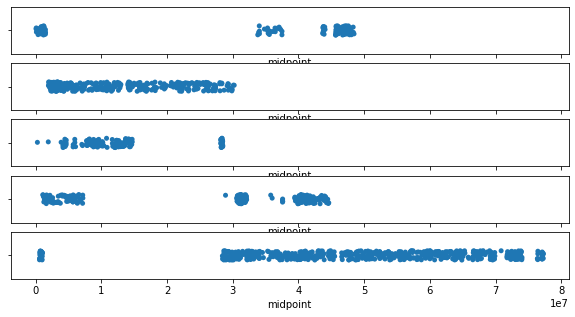

In [24]:
max_finz = finz_locs_df.groupby(['species', 'chrom']).count().reset_index().groupby('gene').max()
max_finz_df = finz_locs_df.loc[finz_locs_df.chrom.isin(max_finz.chrom)]
max_chroms = dict(zip(max_finz.species, max_finz.chrom))

print(set(max_finz_df.species))

fig, axes = plt.subplots(figsize=(10, 5), nrows=5, sharex=True)
for i, sp in enumerate(['Danio_kyathit', 'Danio_aesculapii',  'Onychostoma_macrolepis', 'Gobiocypris_rarus', 'Danio_rerio']):
    sns.stripplot(data=max_finz_df.loc[max_finz_df.species == sp],
                  x='midpoint',
                  ax=axes[i])


In [37]:
drerio_midpoints, drerio_chroms = get_midpoints('Danio_rerio', set(tpm_df.loc[tpm_df.finz == True, 'gene']))

# Generate location dataframe
finz_locs_df = tpm_df.loc[(tpm_df.finz == True) & (tpm_df.stageName == 'Dome')] \
    .copy() \
    .reset_index(drop=True)
finz_locs_df['chromosome'] = finz_locs_df.gene.apply(drerio_chroms.get)
finz_locs_df['position'] = finz_locs_df.gene.apply(drerio_midpoints.get)

density_df = []
for teclass in ['LTR', 'LINE', 'SINE', 'DNA']:

    df = pd.read_csv(f'/Users/jonwells/Projects/feschottelab/drerio-tes/data/circosfig/{teclass}.density.young2.txt',
                             sep='\t', 
                             names=['chr', 'start', 'stop', 'density'])
    df = df.loc[df.chr == '4']
    df.loc[df.chr == '4', 'chr'] = 'NC_007115.7'
    df['midpoint'] = df['stop'] - 1000000
    df['teclass'] = teclass
    density_df.append(df)

density_df = pd.concat(density_df)
density_df.density *= 100
print(density_df)

             chr     start      stop  density  midpoint teclass
484  NC_007115.7         0   2000000  0.05015   1000000     LTR
485  NC_007115.7   2000000   4000000  0.00720   3000000     LTR
486  NC_007115.7   4000000   6000000  0.01220   5000000     LTR
487  NC_007115.7   6000000   8000000  0.00000   7000000     LTR
488  NC_007115.7   8000000  10000000  0.09085   9000000     LTR
..           ...       ...       ...      ...       ...     ...
519  NC_007115.7  70000000  72000000  6.29790  71000000     DNA
520  NC_007115.7  72000000  74000000  1.96470  73000000     DNA
521  NC_007115.7  74000000  76000000  2.89780  75000000     DNA
522  NC_007115.7  76000000  78000000  1.58870  77000000     DNA
523  NC_007115.7  78000000  78093715  2.02529  77093715     DNA

[160 rows x 6 columns]


/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


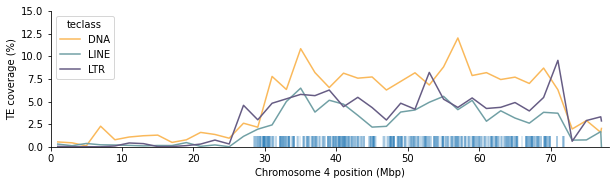

In [41]:
colours = {'DNA': '#fab95b', 
           'LTR': '#665c84', 
           'LINE': '#71a0a5'}

fig, ax = plt.subplots(figsize=(10, 2.5))
sns.rugplot(data=finz_locs_df.loc[finz_locs_df.chromosome == 'NC_007115.7'], x='position', height=0.08, lw=0.3)
sns.lineplot(data=density_df.loc[density_df.teclass.isin(['LTR', 'LINE', 'DNA'])], 
             x='midpoint', 
             y='density', 
             hue='teclass',
             hue_order=['DNA', 'LINE', 'LTR'],
             palette=[colours['DNA'], colours['LINE'], colours['LTR']])
ax.set_xlim(0, get_chromsizes('Danio_rerio')['NC_007115.7'])
ax.set_ylim(0, 15)
ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70])
ax.set_xlabel('Chromosome 4 position (Mbp)')
ax.set_ylabel('TE coverage (%)')
sns.despine()
plt.savefig('../figs/chr4q_znf_density.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [27]:
def get_siblings(tree, labels):
    siblings = {}
    nodedict = {label.strip("'"): node for label, node in tree.label_to_node().items()}
    nearest_neighbor = {}
    for label in labels:
        node = nodedict[label]
        parent = node.get_parent()
        children = parent.child_nodes()
        children.remove(node)
        nearest_label, nearest_distance = '', np.inf
        if children[0].is_leaf():
            nearest_neighbor[label] = children[0].get_label().strip("'"), tree.distance_between(node, children[0])
        else:
            for leafnode in children[0].traverse_leaves():
                currdist = tree.distance_between(node, leafnode)
                if currdist < nearest_distance:
                    nearest_label, nearest_distance = leafnode.get_label().strip("'"), currdist
            nearest_neighbor[label] = (nearest_label, nearest_distance)
    return nearest_neighbor


In [14]:
tree_df = pd.read_csv('../data/annotations.txt', header=None, names=['label'])
tree_df['species'] = tree_df.label.apply(lambda x: '_'.join(x.split('_')[:2]))
tree_df['gene'] = tree_df.label.apply(lambda x: re.search('_(g\d{1,4})\.t1_', x).group(1))
tree_df = tree_df.loc[tree_df.species == 'Danio_rerio'] \
    .merge(tpm_df.loc[tpm_df.stageName == 'Dome'], on='gene')
tree_df = tree_df.loc[~pd.isna(tree_df.cluster)]
gene_labels = dict(zip(tree_df.gene, tree_df.label))

tree = open('../data/selection-analysis/pairwise_needleman_longlabel.nwk').read().replace('\n', '')
tree = ts.read_tree(tree, 'Newick')
brlens = {label.strip("'"): node.get_edge_length() for label, node in tree.label_to_node().items()}
tree_df['brlens'] = tree_df.label.apply(brlens.get)

nn = get_siblings(tree, set(tree_df.loc[tree_df.species == 'Danio_rerio', 'label']))
tree_df['nn_species'] = tree_df.label.apply(lambda x: '_'.join(nn[x][0].split('_')[:2]))
tree_df['nn_gene'] = tree_df.label.apply(lambda x: nn[x][0].split('_')[2].strip('.t1'))
tree_df['nn_dist'] = tree_df.label.apply(lambda x: nn[x][1])
tree_df['paralog'] = True
tree_df.loc[tree_df.species != tree_df.nn_species, 'paralog'] = False

drerio_midpoints, drerio_chroms = get_midpoints('Danio_rerio', set(tree_df.loc[tree_df.finz == True, 'gene']))
dkyathit_midpoints, dkyathit_chroms = get_midpoints('Danio_kyathit', set(tree_df.loc[tree_df.nn_species == 'Danio_kyathit', 'nn_gene']))

tree_df['chromosome'] = tree_df.gene.apply(drerio_chroms.get)
tree_df['position'] = tree_df.gene.apply(drerio_midpoints.get)
tree_df['nn_chromosome'] = tree_df.nn_gene.apply(dkyathit_chroms.get)
tree_df['nn_position'] = tree_df.nn_gene.apply(dkyathit_midpoints.get)

print(tree_df.head())
print(dkyathit_midpoints)

                            label      species   gene stageName       tpm  \
0  Danio_rerio_g2463.t1_[len=312]  Danio_rerio  g2463      Dome  0.772221   
1  Danio_rerio_g2088.t1_[len=398]  Danio_rerio  g2088      Dome  1.393288   
2  Danio_rerio_g2014.t1_[len=473]  Danio_rerio  g2014      Dome  1.759247   
3  Danio_rerio_g2025.t1_[len=429]  Danio_rerio  g2025      Dome  0.477789   
4  Danio_rerio_g2016.t1_[len=388]  Danio_rerio  g2016      Dome  7.269796   

                cluster  finz  expressed   brlens           nn_species  \
0                    NC  True      False  0.10162  Danio_jaintianensis   
1                    NC  True      False  0.21894  Danio_jaintianensis   
2                    NC  True      False  0.13646        Danio_tinwini   
3                    NC  True      False  0.13142  Danio_jaintianensis   
4  Maternally deposited  True       True  0.08965  Danio_jaintianensis   

  nn_gene  nn_dist  paralog                     chromosome  position  \
0    g147  0.17582  

In [113]:
mp = len(tree_df.loc[(tree_df.cluster == 'Maternally deposited') & (tree_df.paralog == True)])
mo = len(tree_df.loc[(tree_df.cluster == 'Maternally deposited') & (tree_df.paralog == False)])
nmp = len(tree_df.loc[(tree_df.cluster.isin(['Dome', 'Late'])) & (tree_df.paralog == True)])
nmo = len(tree_df.loc[(tree_df.cluster.isin(['Dome', 'Late'])) & (tree_df.paralog == False)])

print(np.array([[mp, mo], [nmp, nmo]]))
print(stats.fisher_exact([[mp, mo], [nmp, nmo]]))

[[  2  32]
 [220  41]]
(0.011647727272727273, 2.8549245758153425e-20)


In [120]:
print(tree_df.loc[(tree_df.nn_species == 'Danio_kyathit') & (tree_df.cluster == 'Maternally deposited')])

                              label      species   gene stageName        tpm  \
8    Danio_rerio_g2199.t1_[len=323]  Danio_rerio  g2199      Dome  11.152755   
21   Danio_rerio_g2062.t1_[len=236]  Danio_rerio  g2062      Dome   3.620478   
27   Danio_rerio_g2087.t1_[len=377]  Danio_rerio  g2087      Dome  37.822385   
45   Danio_rerio_g2112.t1_[len=461]  Danio_rerio  g2112      Dome   6.356532   
749  Danio_rerio_g2131.t1_[len=311]  Danio_rerio  g2131      Dome  25.719910   
751  Danio_rerio_g2221.t1_[len=492]  Danio_rerio  g2221      Dome   9.290696   
756  Danio_rerio_g2465.t1_[len=187]  Danio_rerio  g2465      Dome   8.035412   
811  Danio_rerio_g2026.t1_[len=545]  Danio_rerio  g2026      Dome   8.875804   

                  cluster  finz  expressed   brlens     nn_species nn_gene  \
8    Maternally deposited  True       True  0.20511  Danio_kyathit   g2542   
21   Maternally deposited  True       True  0.19840  Danio_kyathit   g2374   
27   Maternally deposited  True       True  0

In [88]:
tree_df2 = pd.DataFrame \
             .from_dict(brlens,orient='index') \
             .drop('') \
             .reset_index() \
             .rename({'index': 'label', 0: 'tbl'}, axis=1)
tree_df2['species'] = tree_df2.label.apply(lambda x: '_'.join(x.split('_')[:2]))
tree_df2['gene'] = tree_df2.label.apply(lambda x: re.search('_(g\d{1,4})\.t1_', x).group(1))

tree = open('../data/selection-analysis/pairwise_needleman_longlabel.nwk').read().replace('\n', '')
tree = ts.read_tree(tree, 'Newick')
nn = get_siblings(tree, set(tree_df2.label))

tree_df2['nn_species'] = tree_df2.label.apply(lambda x: '_'.join(nn[x][0].split('_')[:2]))
tree_df2['nn_gene'] = tree_df2.label.apply(lambda x: nn[x][0].split('_')[2].strip('.t1'))
tree_df2['nn_dist'] = tree_df2.label.apply(lambda x: nn[x][1])
tree_df2['paralog'] = True
tree_df2.loc[tree_df2.species != tree_df2.nn_species, 'paralog'] = False

nparas = tree_df2[['label', 'species', 'paralog']].groupby(['species', 'paralog']).count().reset_index()
print(nparas)

print(tree_df2.head())

                         species  paralog  label
0            Anabarilius_grahami    False    230
1            Anabarilius_grahami     True     13
2              Carassius_auratus    False    134
3              Carassius_auratus     True     44
4        Ctenopharyngodon_idella    False    209
5        Ctenopharyngodon_idella     True      8
6                Culter_alburnus    False    280
7                Culter_alburnus     True     43
8                Cyprinus_carpio    False    158
9                Cyprinus_carpio     True     29
10              Danio_aesculapii    False    139
11              Danio_aesculapii     True    270
12            Danio_albolineatus    False    148
13            Danio_albolineatus     True    192
14                 Danio_choprai    False     63
15                 Danio_choprai     True      7
16           Danio_jaintianensis    False     90
17           Danio_jaintianensis     True      3
18                 Danio_kyathit    False    189
19                 D

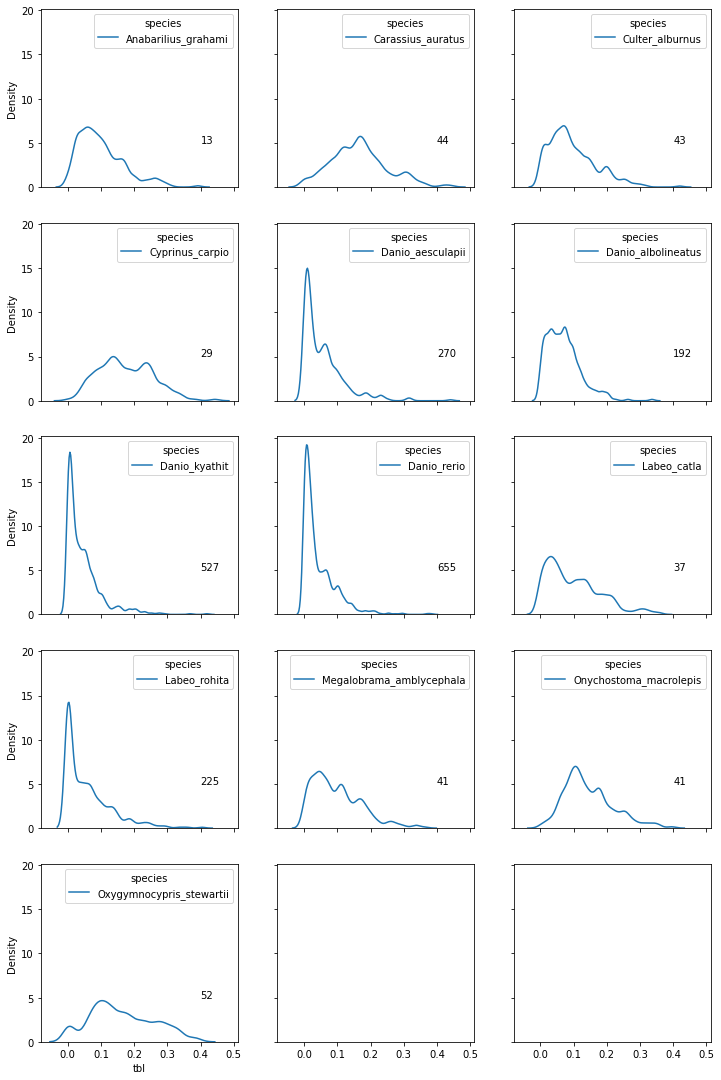

In [104]:
fig, ax = plt.subplots(figsize=(12, 19), nrows=5, ncols=3, sharey=True, sharex=True)
i, j = 0, 0
splist = nparas.loc[(nparas.paralog == True) & (nparas.label > 10)]

for species in sorted(splist.species):
    sns.kdeplot(data=tree_df2.loc[tree_df2.species == species],
                x='tbl',  
                hue='species',
                ax=ax[i][j],
                bw_adjust=0.5)
    ax[i][j].text(0.4, 5, s=int(splist.loc[splist.species==species, 'label']))
    j += 1
    if j > 2:
        i += 1
        j = 0

    
